In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [25]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: -0.9245655858406157, node: PEPTIDE1{[ac].F.Q.S.K.D.H.V.F.V.D.G.Y.F.E.R.L.A.A.K.L.[am]}$$$$
1- time: 0.10, count_rollouts: 3, reward: 0.8953389474416062, node: PEPTIDE1{[ac].D.V.S.T.S.L.A.S.S.Q.G.C}$$$$
2- time: 0.13, count_rollouts: 4, reward: -0.8840130335515616, node: PEPTIDE1{R.P.[dK].P.Q.[dQ].F.F.G.L.[dM].[am]}$$$$
3- time: 0.16, count_rollouts: 5, reward: -0.8917452954545892, node: PEPTIDE1{Y.P.S.K.P.[dD].C.P.A.C.A.V}$$$$
4- time: 0.23, count_rollouts: 7, reward: -0.8859645817160372, node: PEPTIDE1{F.V.P.T.N.V.K.S.E.A.F}$$$$
5- time: 0.26, count_rollouts: 8, reward: 0.9326496673303635, node: PEPTIDE1{A.A.R.A.A.A.A.A.A}$$$$
6- time: 0.28, count_rollouts: 9, reward: -0.8938623862406938, node: PEPTIDE1{T.P.R.A.R.R.R.K.K.R.A}$$$$
7- time: 0.31, count_rollouts: 10, reward: -0.7872003944959679, node: PEPTIDE1{K.G.F.W.G.I.L.V.K}$$$$
8- time: 0.34, count_rollouts: 11, reward: 0.43058893058670505, node: PEPTIDE1{L.A.A.P.[am]}$$$$

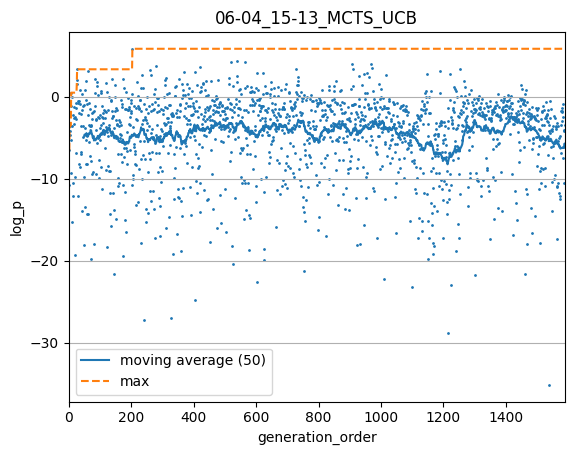

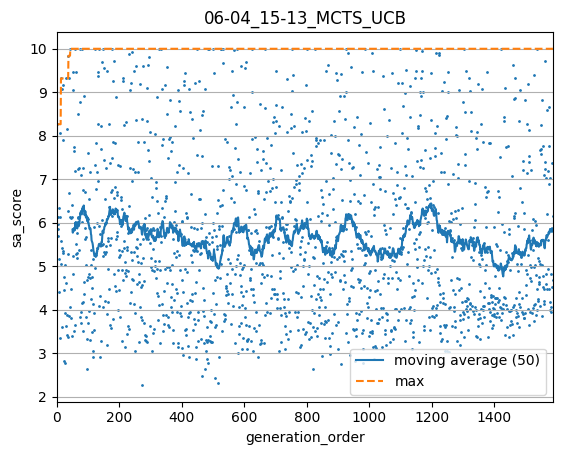

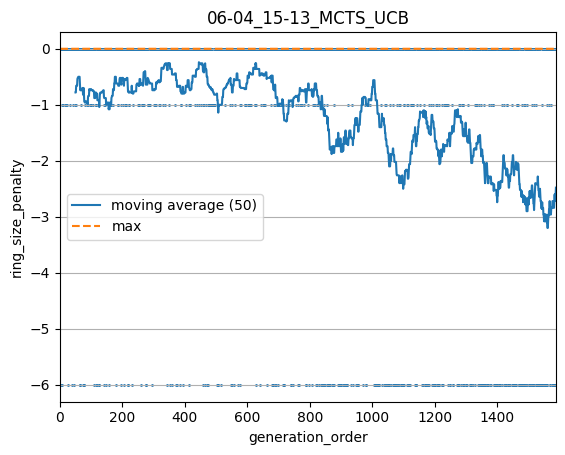

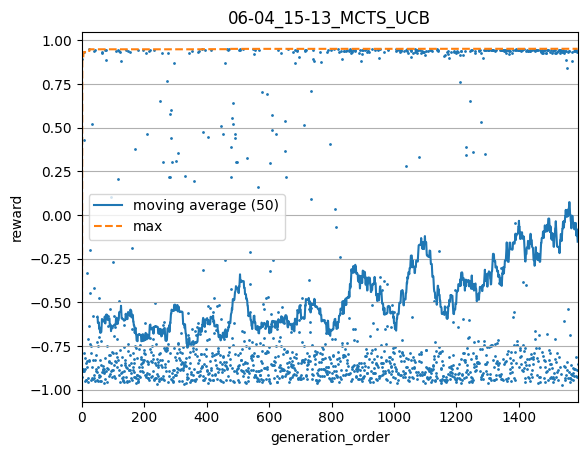

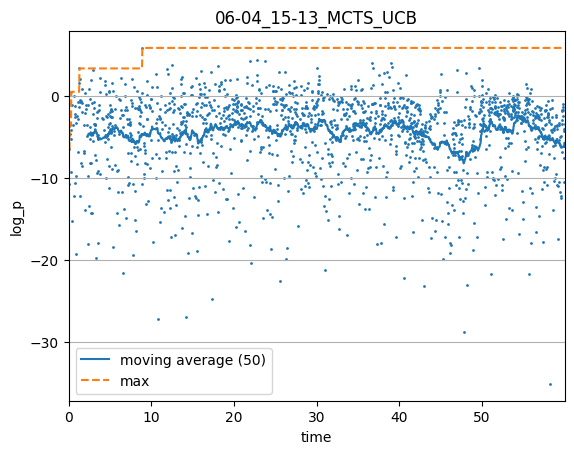

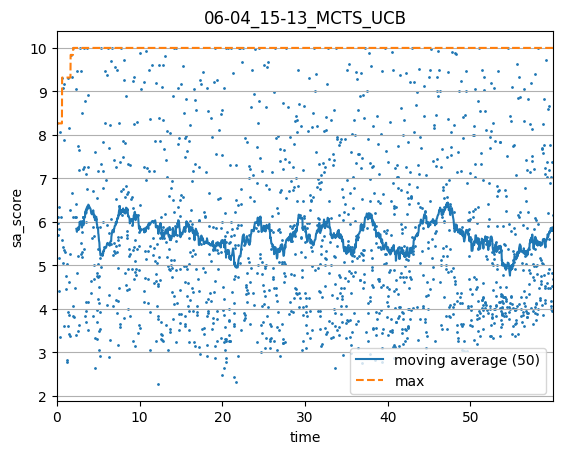

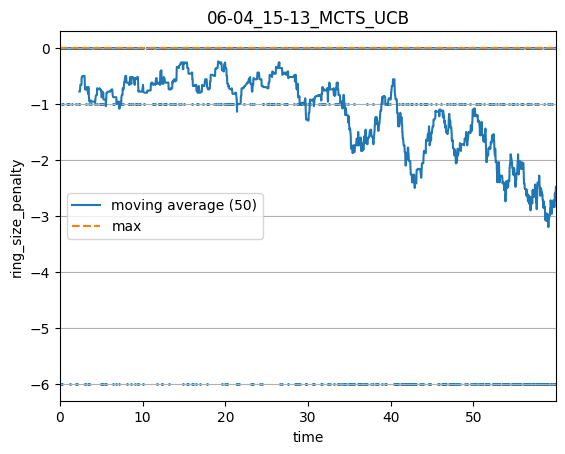

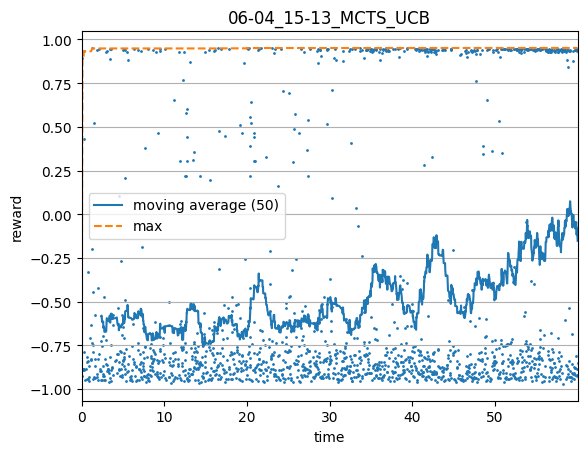

'generation_result/06-04_15-13_MCTS_UCB/setting.yaml'

In [27]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")
generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)